In [7]:
#@title Fix variables, constants
# %%capture
import torch
precision = 1
torch.set_printoptions(precision=precision)
WIDTH, HEIGHT = 3,3
grid_size = (WIDTH, HEIGHT)
print("Width and Height used are {} and {}".format(WIDTH, HEIGHT))
INIT_PROBABILITY = 0.20
min_pixels = max(0, int(WIDTH * HEIGHT * INIT_PROBABILITY))
NUM_LAYERS = 2 # rest hidden and one alpha
ALPHA = 0.6 # To make other cells active (we dont go with other values below 0.6 to avoid dead cells and premature livelihood)
INHERTIANCE_PROBABILITY  = 0.2 # probability that neighboring cells will inherit by perturbation.
parameter_perturbation_probability = 0.2
print("Numbers of layers used are {}".format(NUM_LAYERS))
print("1 for alpha layer and rest {} for hidden".format(NUM_LAYERS-1))
NUM_STEPS = 5
num_steps = NUM_STEPS
print("Numbers of Time Steps are {}".format(NUM_STEPS))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
activation = 'sigmoid' # ['relu','sigmoid','tanh','leakyrelu']
frequency_dicts = []
FPS = 2 # Speed of display for animation of NCA and plots
marker_size = 2 # for plots
everystep_weights = [] # Stores weigths of the NNs from every time step.
KMEANS_K = 5

Width and Height used are 3 and 3
Numbers of layers used are 2
1 for alpha layer and rest 1 for hidden
Numbers of Time Steps are 5
Using device: cuda


------------------------------------------------------------------
Model Summary
Input Size: 18
FC Layer 1 Weight Parameters: 18 * 2 = 36
FC Layer 1 Bias Parameters: 2
FC Layer 2 Weight Parameters: 2 * 2 = 4
FC Layer 2 Bias Parameters: 2
Total Number of Parameters: 44
Layer 1: fc1, Input Size: 18, Output Size: 2
Layer 2: fc2, Input Size: 2, Output Size: 2
------------------------------------------------------------------
cagrid before
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0')
cagrid after
tensor([[[0.0, 0.0, 0.0],
         [0.0, 0.0, 0.0],
         [1.0, 0.0, 0.0]],

        [[0.0, 0.0, 0.0],
         [0.0, 0.0, 0.0],
         [0.7, 0.0, 0.0]]], device='cuda:0')
------------------------------------------------------------------
Weight Parameters:
Individual Weight Parameters:
Layer: fc1.weight, Shape: torch.Size([2, 18])
Weights: Parameter containing:
tensor([[0., 0., 0.

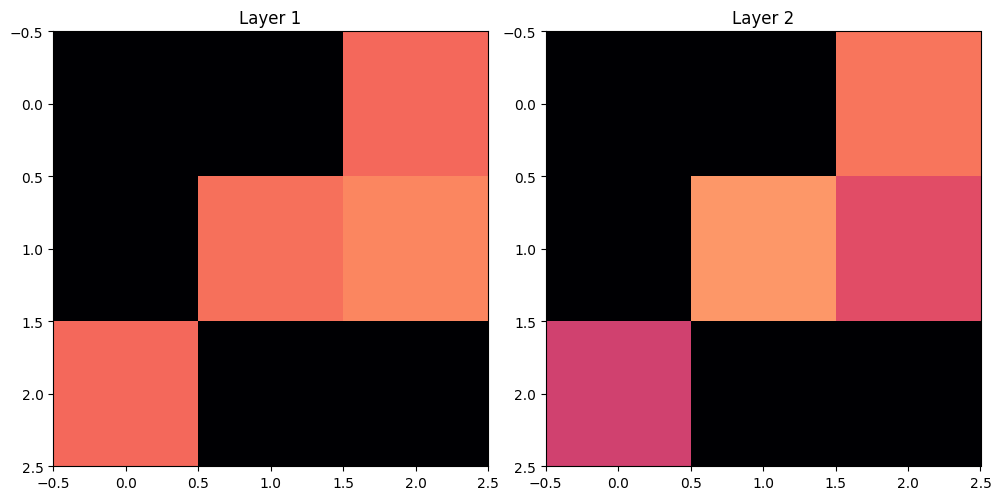

In [8]:
#@title Simulation with debug
# %%capture
import torch
import os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import random
import copy
from collections import Counter
from matplotlib.colors import Normalize

ca_grids_for_later_analysis = []

# def custom_activation(x):
#     result = 0.05 * (x + 2)
#     result = max(0, min(0.1, result))
#     return result
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

if(activation == 'sigmoid'):
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.sigmoid = nn.Sigmoid()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.sigmoid(x)
          x = self.fc2(x)
          return x

elif(activation == 'tanh'):
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.tanh = nn.Tanh()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.tanh(x)
          x = self.fc2(x)
          return x


elif(activation == 'relu'):
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.relu = nn.ReLU()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.relu(x)
          x = self.fc2(x)
          return x
else:
  class SimpleNN(nn.Module):
      def __init__(self):
          super(SimpleNN, self).__init__()
          self.fc1 = nn.Linear(9 * NUM_LAYERS, NUM_LAYERS)
          self.leaky_relu = nn.LeakyReLU()
          self.fc2 = nn.Linear(NUM_LAYERS, NUM_LAYERS)
          # Initialize weights and biases to zero
          nn.init.zeros_(self.fc1.weight)
          nn.init.zeros_(self.fc2.weight)
          nn.init.zeros_(self.fc1.bias)
          nn.init.zeros_(self.fc2.bias)
      def forward(self, x):
          x = self.fc1(x)
          x = self.leaky_relu(x)
          x = self.fc2(x)
          return x


ca_nn = SimpleNN().to(DEVICE)

# Calculate the number of parameters stepwise

input_size_fc1 = 9 * NUM_LAYERS
output_size_fc1 = NUM_LAYERS
weight_params_fc1 = input_size_fc1 * output_size_fc1
bias_params_fc1 = output_size_fc1

input_size_fc2 = NUM_LAYERS
output_size_fc2 = NUM_LAYERS
weight_params_fc2 = input_size_fc2 * output_size_fc2
bias_params_fc2 = output_size_fc2

weight_params = weight_params_fc1 + weight_params_fc2
bias_params = bias_params_fc1 + bias_params_fc2
total_params = weight_params + bias_params

print("------------------------------------------------------------------")
print("Model Summary")
# Print the equations and the total number of parameters
print(f"Input Size: {input_size_fc1}")
print(f"FC Layer 1 Weight Parameters: {input_size_fc1} * {output_size_fc1} = {weight_params_fc1}")
print(f"FC Layer 1 Bias Parameters: {output_size_fc1}")
print(f"FC Layer 2 Weight Parameters: {input_size_fc2} * {output_size_fc2} = {weight_params_fc2}")
print(f"FC Layer 2 Bias Parameters: {output_size_fc2}")
print(f"Total Number of Parameters: {total_params}")
for name, layer in ca_nn.named_children():
    if isinstance(layer, nn.Linear):
        input_size = layer.in_features
        output_size = layer.out_features
        if name == "fc1":
            print(f"Layer 1: {name}, Input Size: {input_size}, Output Size: {output_size_fc1}")
        elif name == "fc2":
            print(f"Layer 2: {name}, Input Size: {input_size_fc2}, Output Size: {output_size_fc2}")

print("------------------------------------------------------------------")


ca_grid = torch.zeros((NUM_LAYERS, WIDTH, HEIGHT), device=DEVICE, dtype=torch.float32)
print("cagrid before")
print(ca_grid)
random_tensor = torch.ones((WIDTH, HEIGHT))
sorted_values, indices = random_tensor.view(-1).sort()
mask = torch.zeros_like(random_tensor)
shuffled_indices = indices.tolist()  # Convert indices to a list
random.shuffle(shuffled_indices)     # Shuffle the list
random_positions = shuffled_indices[:min_pixels]
mask.view(-1)[random_positions] = 1.0
for layer in range(0,NUM_LAYERS):
  if (layer==0):
    ca_grid[layer] = mask * (ALPHA + (1 - ALPHA) * random_tensor)  # Initialize the alpha channel with values greater than ALPHA
  else:
    ca_grid[layer] = mask * (ALPHA + (1 - ALPHA) * random_tensor * random.random())  # Initialize the other channel with values greater than ALPHA
# ca_grid[0] = mask * (random_tensor) # Initialising only alpha channel
# ca_grid[1] = mask * (random_tensor * random.random()) # Initialising a little amount of channel 1 with the idea that if a pixel is having some intensity in alpha, it should have some values in other channels.
print("cagrid after")
print(ca_grid)
print("------------------------------------------------------------------")

print("Weight Parameters:")

print("Individual Weight Parameters:")
for name, param in ca_nn.named_parameters():
    if 'weight' in name:
        print(f"Layer: {name}, Shape: {param.shape}")
        print(f"Weights: {param}")

print("------------------------------------------------------------------")
print("Bias Parameters for FC1:")
print(ca_nn.fc1.bias)
print("Bias Parameters for FC2:")
print(ca_nn.fc2.bias)

print("------------------------------------------------------------------")

print("Entering update loop >>>>>")

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)
        nn.init.zeros_(module.bias)
def initialize_weights_to_zero(module):
    if isinstance(module, nn.Linear):
        nn.init.zeros_(module.weight)
        nn.init.zeros_(module.bias)

# Create a list of neural networks, one for each pixel
ca_nn_list = [SimpleNN().to(DEVICE) for _ in range(WIDTH * HEIGHT)]

# Initialize the weights for neural networks associated with live pixels
for i in range(WIDTH):
    for j in range(HEIGHT):
        if ca_grid[0, i, j] > ALPHA:
            ca_nn_list[i * WIDTH + j].apply(initialize_weights)




# import torch
# import random

# # Assuming ca_nn_list is a list of neural networks with learnable parameters

# # Define a simple neural network for demonstration
# class SimpleNN(torch.nn.Module):
#     def __init__(self):
#         super(SimpleNN, self).__init__()
#         self.fc1 = torch.nn.Linear(3, 2)

#     def forward(self, x):
#         return self.fc1(x)

# # Initialize a list of neural networks
# ca_nn_list = [SimpleNN() for _ in range(3)]  # Assuming 3 neural networks in the list

# # Print original weights
# print("Original Weights:")
# for idx, nn in enumerate(ca_nn_list):
#     print(f"Network {idx + 1} weights:")
#     for name, param in nn.named_parameters():
#         if 'weight' in name:
#             print(name, ":\n", param.data)
#     print("-------------------------")

# # Perturb weights using the modified code
# param_perturbation_percentage = 0.8

# for idx, nn in enumerate(ca_nn_list):
#     for name, param in nn.named_parameters():
#         if 'weight' in name:
#             mask = torch.rand_like(param.data) < param_perturbation_percentage
#             with torch.no_grad():
#                 param.data += mask * torch.randn_like(param.data)  # Add random noise only to selected weights

# # Print perturbed weights
# print("\nPerturbed Weights:")
# for idx, nn in enumerate(ca_nn_list):
#     print(f"Network {idx + 1} weights:")
#     for name, param in nn.named_parameters():
#         if 'weight' in name:
#             print(name, ":\n", param.data)
#     print("-------------------------")


def update_ca(ca_grid, ca_nn_list):
    print("")
    print("")

    print("Inside updateCA function")
    new_ca_grid = ca_grid.clone()
    print("New CA grid initialised temporarily:")
    print(new_ca_grid)

    def process_neighborhood(i, j, idx, ca_nn_list):
        print("")
        print("")
        print("Inside process_neighborhood function")
        neighborhood = torch.zeros(9 * NUM_LAYERS, device=DEVICE)
        print("Empty tensor for neighborhood initialised temporarily:")
        print(neighborhood)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                ni, nj = (i + dx) % WIDTH, (j + dy) % HEIGHT
                for l in range(NUM_LAYERS):
                    neighborhood[(dx + 1) * 3 + (dy + 1) + l * 9] = ca_grid[l, ni, nj]
        neighborhood = torch.unsqueeze(neighborhood, 0)
        print("Neighborhood is :")
        print(neighborhood)
        output = None  # Initialize output to None
        print("------------------------------------------------------------------")

        print("Weight Parameters at this step (no perturbation has happened at this step):")

        print("Individual Weight Parameters:")
        for name, param in ca_nn_list[idx].named_parameters():
            if 'weight' in name:
                print(f"Layer: {name}, Shape: {param.shape}")
                print(f"Weights: {param}")


        print("------------------------------------------------------------------")
        print("Bias Parameters at this step for FC1:")
        print(ca_nn_list[idx].fc1.bias)
        print("Bias Parameters at this step for FC2:")
        print(ca_nn_list[idx].fc2.bias)

        print("------------------------------------------------------------------")
        if((neighborhood > ALPHA).any()):
          output = ca_nn_list[idx](neighborhood)
          print("🙋Inside if condition for (neighborhood > ALPHA).any() ")
          if(random.random() < INHERTIANCE_PROBABILITY):
            print("🙋🙋Reaching towards inheritance and performing pertubation too - inside if condition - random.random() < INHERTIANCE_PROBABILITY.")
            high_alpha_pixels = [(dx, dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if ca_grid[0, (i + dx) % WIDTH, (j + dy) % HEIGHT] > ALPHA] # Find neighboring pixels with alpha values greater than ALPHA
            if high_alpha_pixels:
                # check again for livelihood of the pixels (if this if condition passed, that means there is at least one element that is greater than alpha.)
                current_alpha_value = ca_grid[0, i, j]
                print("current_alpha_value: ",current_alpha_value.item())
                print("current_alpha_value: ",current_alpha_value.item())
                print("current_alpha_value: ",current_alpha_value.item())
                print("current_alpha_value: ",current_alpha_value.item())
                high_alpha_values = [ca_grid[0, (i + dx) % WIDTH, (j + dy) % HEIGHT] for dx, dy in high_alpha_pixels]
                print(">>>> Hello! I am pixel at position {}, {}. My alive neighbors are at the positions {} whose values in Alpha channel are {}.".format(i, j, high_alpha_pixels, high_alpha_values))
                selected_pixel = random.choice(high_alpha_pixels)  # Select any random live pixel in the neighborhood
                print("I am selecting pixel {}".format(selected_pixel))
                ni, nj = (i + selected_pixel[0]) % WIDTH, (j + selected_pixel[1]) % HEIGHT

                # Check if the selected neural network has any non-zero weights
                selected_nn_idx = ni * WIDTH + nj
                selected_nn = ca_nn_list[selected_nn_idx]
                has_nonzero_weights_selected = any(torch.any(param != 0) for param in selected_nn.parameters())

                current_nn_idx = idx
                current_nn = ca_nn_list[current_nn_idx]
                has_nonzero_weights_current = any(torch.any(param != 0) for param in current_nn.parameters())

                if not has_nonzero_weights_current:
                    # Copy the neural network from the selected neighboring pixel
                    ca_nn_list[idx] = copy.deepcopy(selected_nn)
                    print("AM I EVEN ENTERING HERE")
                    print("AM I EVEN ENTERING HERE")
                    print("AM I EVEN ENTERING HERE")
                    print("AM I EVEN ENTERING HERE")
                    # Perturb neural network weights
                    for name, param in ca_nn_list[idx].named_parameters():
                        if 'weight' in name:
                            mask = torch.rand_like(param.data) < parameter_perturbation_probability
                            with torch.no_grad():
                                param.data += mask * torch.randn_like(param.data)
                else:
                    ca_nn_list[idx] = copy.deepcopy(selected_nn)
        else:
          ca_nn_list[idx].apply(initialize_weights_to_zero)
        can_nn_updated_single = copy.deepcopy(ca_nn_list[idx])
        print("Ouptut from NN is :")
        print(output)
        print("------------------------------------------------------------------")

        print("Weight Parameters at this step (if perturbation, then it has already finished at this step):")

        print("Individual Weight Parameters:")
        for name, param in ca_nn_list[idx].named_parameters():
            if 'weight' in name:
                print(f"Layer: {name}, Shape: {param.shape}")
                print(f"Weights: {param}")

        print("------------------------------------------------------------------")
        print("Bias Parameters at this step for FC1:")
        print(ca_nn_list[idx].fc1.bias)
        print("Bias Parameters at this step for FC2:")
        print(ca_nn_list[idx].fc2.bias)

        print("------------------------------------------------------------------")

        if output is not None:
            # print("returning output from this function: this 1 should be same as this 2", output.squeeze().tolist())
            return output.squeeze().tolist(), can_nn_updated_single
        else:
            # Return a default value (all zeros) if output is None
            return [0.0] * NUM_LAYERS, can_nn_updated_single

    idx = 0  # Index for the neural networks
    ca_nn_list_temp = []
    for i in range(WIDTH):
        for j in range(HEIGHT):
            print("------------------------------------------------------------------")
            print(">>Right now I am using pixel at WIDTH {}, HEIGHT {}".format(i,j))
            updated_values, can_nn_updated_single = process_neighborhood(i, j, idx, ca_nn_list)
            print("returning output from process_neighborhood function which is same as the ouptut of NN in high precision: ", updated_values)
            for layer in range(NUM_LAYERS):
                new_ca_grid[layer, i, j] = updated_values[layer]
            ca_nn_list_temp.append(can_nn_updated_single)
            idx += 1

    print("⏩⏩⏩Final updated grid :")
    print(new_ca_grid)
    print("⏩⏩⏩Final updated grid (and the values are set to 0 or dead for the pixels are below ALPHA.):")
    new_ca_grid_temp = new_ca_grid.clone()
    print("now replace all pixels with their corresponding sigmoid values.")
    # now replace all pixels with their corresponding sigmoid values.
    for x in range(WIDTH):
      for y in range(HEIGHT):
        for layer in range(NUM_LAYERS):
          updated_value = sigmoid(new_ca_grid_temp[layer, x, y].cpu().numpy())
          new_ca_grid_temp[layer, x, y] = updated_value # setting a value between 0 and 1 for the alive pixels.
    print(new_ca_grid_temp)
    print("⏩⏩⏩now we will check for the ALPHA values as threshold")
    # now we will check for the ALPHA values as threshold
    for x in range(WIDTH):
      for y in range(HEIGHT):
          # Check if any value in channel 0 is less than ALPHA at the current position
          if (new_ca_grid_temp[0, x, y] <= ALPHA):
            # If any value is less than ALPHA, set values in all layers at the current position to 0
            for layer in range(NUM_LAYERS):
                new_ca_grid_temp[layer, x, y] = 0.0

    print(new_ca_grid_temp)
    return new_ca_grid_temp, ca_nn_list_temp


if not os.path.exists('sim_frames'):
    os.makedirs('sim_frames')

metadata = dict(title='Neural CA Simulation', artist='AI', comment='Neural CA Simulation')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
all_colormaps = plt.colormaps()
# colormaps = all_colormaps
colormaps = ['magma']
fig, axes = plt.subplots(1, NUM_LAYERS, figsize=(5 * NUM_LAYERS, 5))
plt.tight_layout()
# plt.close(fig)
import time
stamp = int(time.time())
with writer.saving(fig, "NCA_{}.mp4".format(stamp), dpi=100):
    for frame in range(NUM_STEPS+1):
        # append NN weithts here
        weights_list = []
        for network in ca_nn_list:
            state_dict = network.state_dict()
            flattened_params = []
            for param in state_dict.values():
                flattened_params.extend(param.view(-1).tolist())
            weights_list.append(flattened_params)
        everystep_weights.append(weights_list)
        if(frame == 0):
          ca_grid = ca_grid
          # Not inlcuding initial pixles and their values, so the plot should show only ALPHA values!!!!
          # precision_multiplier = 10 ** precision
          # rounded_grid = (ca_grid * precision_multiplier).round() / precision_multiplier
          # unique_values, value_counts = torch.unique(rounded_grid, return_counts=True)
          # frequency_dict = {value.item(): count.item() for value, count in zip(unique_values, value_counts)}
          # frequency_dicts.append(frequency_dict)
          grid_data = ca_grid[layer].cpu().numpy()
          min_value = 0
          max_value = 1
          norm = Normalize(vmin=min_value, vmax=max_value)
          for layer in range(NUM_LAYERS):
              ax = axes[layer]
              ax.clear()
              ax.imshow(ca_grid[layer].cpu().numpy(), cmap=colormaps[0],interpolation='none', norm=norm)
              ax.set_title(f'Layer {layer + 1}')
          plt.savefig(os.path.join('sim_frames', f'frame_{frame:07d}.pdf'),format='pdf')
          writer.grab_frame()
        else:
          grid_data = ca_grid[layer].cpu().numpy()
          min_value = 0
          max_value = 1
          norm = Normalize(vmin=min_value, vmax=max_value)
          print("------------------------------------------------------------------")
          print(">>>>>>>>Simulation # {}".format(frame))
          ca_grid, ca_nn_list_updated_main = update_ca(ca_grid, ca_nn_list)
          ca_grids_for_later_analysis.append(ca_grid[0].cpu().numpy())
          precision_multiplier = 10 ** precision
          rounded_grid = (ca_grid[0] * precision_multiplier).round() / precision_multiplier # picking only ALPHA values for plot!!!!!!
          unique_values, value_counts = torch.unique(rounded_grid, return_counts=True)
          frequency_dict = {value.item(): count.item() for value, count in zip(unique_values, value_counts)}
          frequency_dicts.append(frequency_dict)
          for layer in range(NUM_LAYERS):
              ax = axes[layer]
              ax.clear()
              print(ca_grid[layer].cpu().numpy())
              ax.imshow(ca_grid[layer].cpu().numpy(), cmap=colormaps[0],interpolation='none', norm=norm)
              ax.set_title(f'Layer {layer + 1}')
          plt.savefig(os.path.join('sim_frames', f'frame_{frame:07d}.pdf'),format='pdf')
          writer.grab_frame()
          ca_nn_list = copy.deepcopy(ca_nn_list_updated_main)

print("Simulation completed.")
!tar cvf sim_frames.tar sim_frames/

In [9]:
#@title Display the results
import os
import base64
from IPython.display import HTML
filename = "NCA_{}.mp4".format(stamp)
mp4_files = [filename]

video_html = ""
for video_path in mp4_files:
    with open(video_path, "rb") as f:
        video_data = f.read()
        video_base64 = base64.b64encode(video_data).decode("utf-8")
        video_html += f'<video width="1200" controls autoplay loop><source src="data:video/mp4;base64,{video_base64}" type="video/mp4"></video>'

HTML(video_html)